# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

# Starbucks Capstone Challenge

### 1. Import Libraries

In [17]:
# Packages for data processing
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Packages for ML 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression

# Package for model storage
import pickle

UsageError: Line magic function `%` not found.


### 2. Loading Data
The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
profile.json - demographic data for each customer
transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [18]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 3. Data Overview

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


### 4. Data Cleaning
#### Data cleaning for Portfolio
* Seperate channel column to various sources
* Change the column name for table merge

In [19]:
# One time code 
channels_type = ['web', 'email', 'mobile', 'social']
for i in channels_type:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})
# Remove the redundent columns (channels and id)
portfolio = portfolio.drop(['channels'],axis =1)
portfolio.rename(columns={'id':'offer_id'},inplace=True) 
portfolio.offer_type.replace(to_replace = {'bogo':1,'informational':2,'discount':3},inplace = True)
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,2,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,3,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


#### Data cleaning for Profile
* Check for empty cells in the data set
* Fill in the blank cell in Gender columns with str_'Unknown'
* Fill in the income value with mean of the data_set

In [20]:
# One time code
profile['gender'].fillna('Unknown', inplace = True)
profile['income'].fillna('Unknown', inplace = True)
profile.replace(to_replace = {'Unknown':0,'M':1,'F':2,'O':3},inplace = True)

#### Data cleaning for Transcript
* Check for empty cells in the data set
* unpack the jason file with the following items:
    value_list = ['offer id','amount','offer_id','reword'](offer id and offer_id should be treated as equal)
* Create empty columns to extract date from 'value' column
* Fill in the empty cells with data using match data type

In [21]:
# The transcript file have no missing elements
value_list = ['offer id','amount','offer_id','reword']
value_list = ['offer id','amount','offer_id','reword']
transcript['amount'] = float(0)
transcript['reward'] = float(0)
transcript['offer id'] = ''
# Fill in the empty cells with data using match data type   
for i, j in transcript.iterrows():
    for item in j['value']:
        if item == 'amount':
            transcript.at[i, 'amount'] = float(j['value'][item])
        if item == 'reward':
            transcript.at[i, 'reward'] = float(j['value'][item])
        if item == 'offer_id' or item == 'offer id':
            transcript.at[i,'offer id']= j['value'][item]         
# Drop the 'value' column
transcript.drop('value',axis = 1,inplace = True)
#Map event column transaction:0,offer received to 1,offer viewed:2,offer completed:3
transcript.event.replace(to_replace = {'transaction':0,'offer received':1,'offer viewed':2,'offer completed':3},inplace = True)

In [22]:
study_tran = transcript.copy()
study_tran.head()

,person,event,time,amount,reward,offer id
0,78afa995795e4d85b5d9ceeca43f5fef,1,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,1,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,1,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,1,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,1,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0


#### Merge data sets
* Rename correponding columns
* Combine three data sets into one dataframe
* Drop the redundent columns

In [23]:
# Before training model we merge the useful data into one dataframe
study_tran.rename(columns={'person':'user_id', 'offer id':'offer_id','reward':'user_reward'},
                  inplace=True) 
profile.rename(columns={'id':'user_id'},inplace=True) # one-time code
part=pd.merge(study_tran,profile,how='left',on=['user_id']) 
study=pd.merge(part,portfolio,how='left',on=['offer_id'])
study.fillna(0,inplace = True)
study.drop(['became_member_on','user_id','offer_id'],axis = 1,inplace = True)

In [34]:
study.head()

,event,time,amount,user_reward,gender,age,income,reward,difficulty,duration,offer_type,web,email,mobile,social
0,1,0,0.0,0.0,2,75,100000.0,5.0,5.0,7.0,1.0,1.0,1.0,1.0,0.0
1,1,0,0.0,0.0,0,118,0.0,5.0,20.0,10.0,3.0,1.0,1.0,0.0,0.0
2,1,0,0.0,0.0,1,68,70000.0,2.0,10.0,7.0,3.0,1.0,1.0,1.0,0.0
3,1,0,0.0,0.0,0,118,0.0,2.0,10.0,10.0,3.0,1.0,1.0,1.0,1.0
4,1,0,0.0,0.0,0,118,0.0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0


               event           time         amount    user_reward  \
count  306534.000000  306534.000000  306534.000000  306534.000000   
mean        0.954100     366.382940       5.792023       0.537219   
std         1.038119     200.326314      21.337137       1.805208   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000     186.000000       0.000000       0.000000   
50%         1.000000     408.000000       0.000000       0.000000   
75%         2.000000     528.000000       7.100000       0.000000   
max         3.000000     714.000000    1062.280000      10.000000   

              gender            age         income         reward  \
count  306534.000000  306534.000000  306534.000000  306534.000000   
mean        1.284703      60.909367   57248.752178       2.416349   
std         0.670750      26.032030   28414.272438       3.326028   
min         0.000000      18.000000       0.000000       0.000000   
25%         1.000000      43.0000

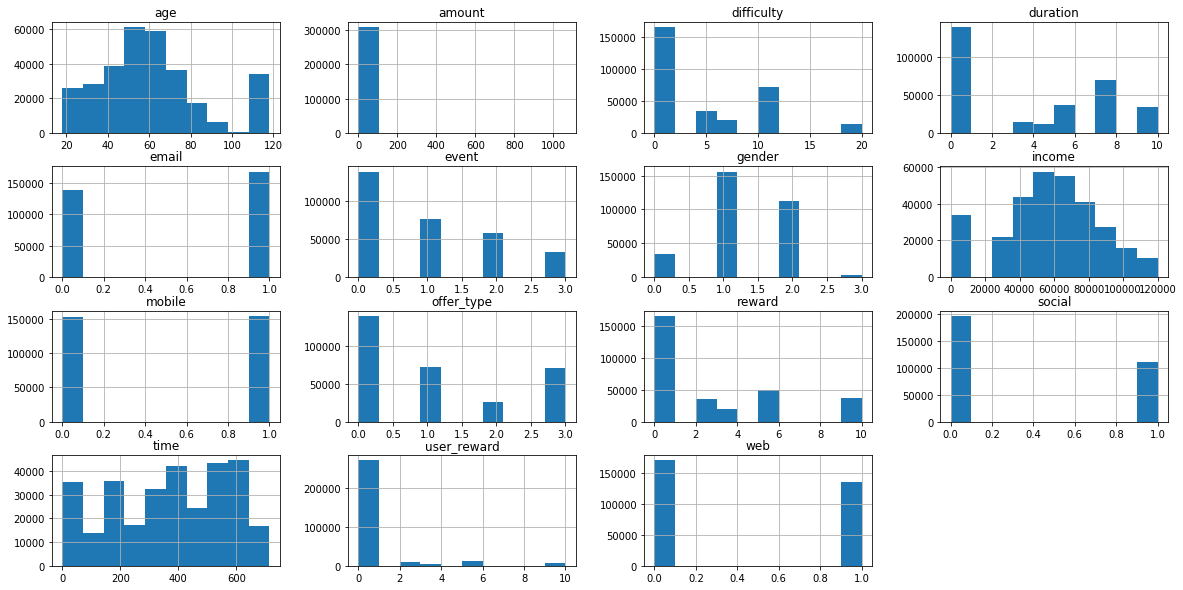

In [33]:
# Provide overview of the data set
plt.rcParams["figure.figsize"] = (20,10)
print(study.describe())
print(study.hist())

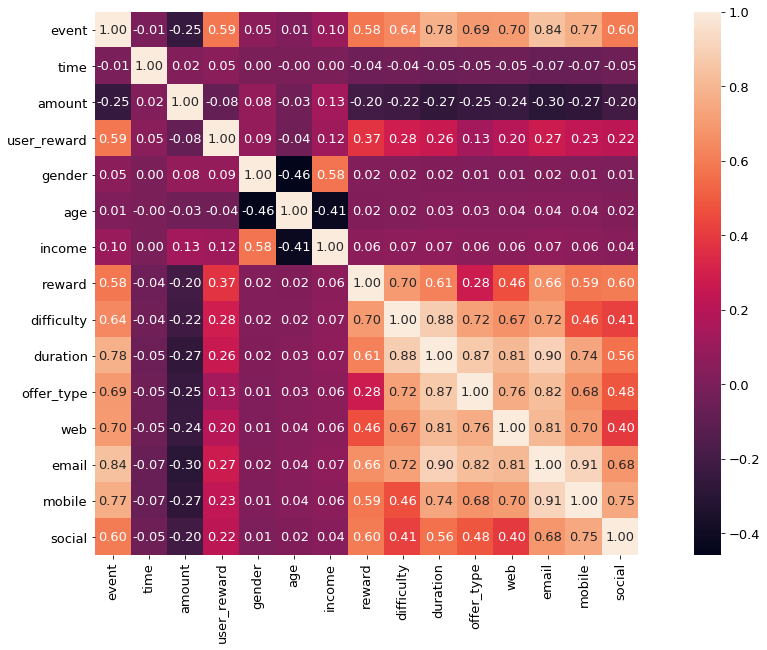

In [58]:
font = {'size': 13}
plt.rc('font', **font)
sns.heatmap(study.corr(), annot=True, fmt=".2f",square=True);

In [45]:
?sns.heatmap

#### Remove unreasonable items
   * For User age, the items which labels as 118 is not reasonable will remove them from the data set

In [19]:
index_remove = study[study['age'] == 118].index
study.drop(index_remove, inplace=True)

### 5. Data Analysis

#### Reserch into user age
* Mean and distribution of user age

* User age distribution with different gender

* User distribution with various age group

In [20]:
#Mean of the users 
study.age.mean()

53.840696284673086

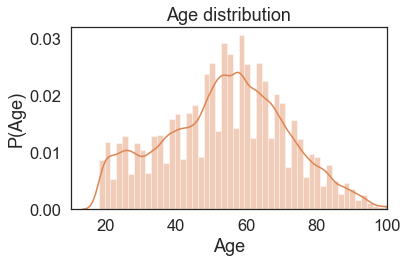

In [32]:
'''
Distribution of user age
Calculate and plot the distribution of user ages
Provide insight for further model construction
'''
x1 = study.age
# Plot the Age distribution of the starbuck user
current_palette = sns.color_palette()
sns.set(font_scale=1.5)
sns.set_style('white')
sns.distplot(x1,color=current_palette[1])
plt.xlabel('Age')
plt.xlim(10, 100)
plt.ylabel('P(Age)')
plt.title('Age distribution')
plt.tight_layout()

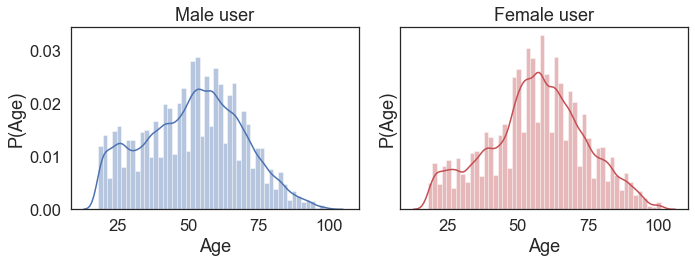

In [25]:
'''
Age distribution with different gender
Logistic of data cleaning:
    1. Seperate the data set into different genders
    2. Count for the user ages
    3. Plot histgram
''' 
x1 = study[study['gender'] == 1].age
x2 = study[study['gender'] == 2].age

#Plot the user data in a histgram
current_palette = sns.color_palette()
sns.set(font_scale=1.5)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(x1,
             color=current_palette[0])
plt.xlabel('Age')
plt.ylabel('P(Age)')
plt.title('Male user')

plt.sca(ax[1])
sns.distplot(x2,
             color=current_palette[3])
plt.xlabel('Age')
plt.ylabel('P(Age)')
plt.title('Female user')
plt.tight_layout()

In [29]:
# Age distribution of users in various age group
Age_basket = ['Young adults','Adults','Middle age','Elder adults','Elderly']
def age_basket (age_list):
    '''
    Allocate users into various age groups
    'Young adults'(<25),'Adults'(25,35),'Middle age'(35,45),'Elder adults'(45,55),'Elderly'(>55)
    INPUT: List of user age (list[int])
    OUTPUT: List of counts in the age basket (list[int])
    '''
    y = a = m = e = o = 0
    for i in age_list:
        if i < 25:
            y += 1
        if i >= 25 and i <35:
            a += 1
        if i >= 35 and i < 45:
            m += 1
        if i >= 45 and i< 55:
            e += 1
        if i >= 55:
            o +=1
    return [y,a,m,e,o]
x1 = age_basket(list(study[study['gender'] == 1].age))
x2 = age_basket(list(study[study['gender'] == 2].age))

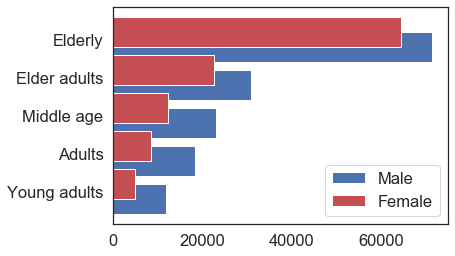

In [30]:
ypos = np.arange(len(Age_basket))
current_palette = sns.color_palette()
plt.yticks(ypos,Age_basket)
plt.barh(ypos-0.2,x1,label = 'Male',color = current_palette[0])
plt.barh(ypos+0.2,x2,label = 'Female',color = current_palette[3])
plt.legend()

### Research into user salary
* Mean of user salary
* Salery distribution of the users with different gender

In [35]:
#Mean of user salary
study[study['income']!=0].income.mean()

64337.00075523717

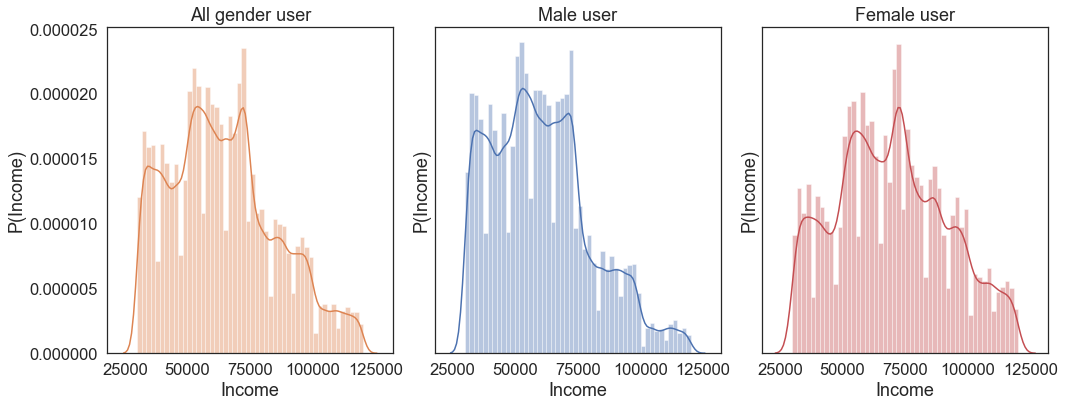

In [39]:
# Salery distribution
study_salary = study[study['income']!=0].copy()
x1 = study_salary.income
x2 = study_salary[study_salary['gender']==1].income
x3 = study_salary[study_salary['gender']==2].income
# Plot the Age distribution of the starbuck user

current_palette = sns.color_palette()
sns.set(font_scale=1.5)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(15, 6),
                       nrows=1,
                       ncols=3,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(x1,
             color=current_palette[1])
plt.xlabel('Income')
plt.ylabel('P(Income)')
plt.title('All gender user')

plt.sca(ax[1])
sns.distplot(x2,
             color=current_palette[0])
plt.xlabel('Income')
plt.ylabel('P(Income)')
plt.title('Male user')

plt.sca(ax[2])
sns.distplot(x3,
             color=current_palette[3])

plt.xlabel('Income')
plt.ylabel('P(Income)')
plt.title('Female user')
plt.tight_layout()

### Research into promote method

* Distribution of successful promote method

* Distribution of promote type

* Usage of the promote method

* Accumulate usage of promote method with different gender

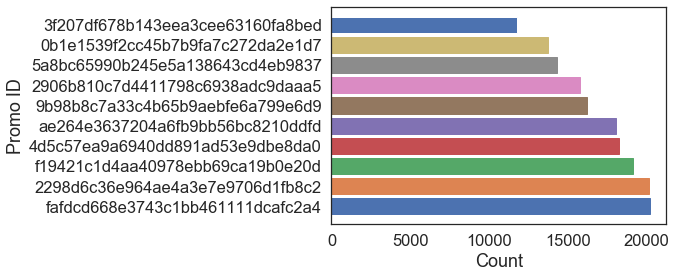

In [40]:
# calculate the number of promo code usage
promo_id = list(transcript['offer id'].value_counts().index)
promo_id.pop(0)
promo_count = list(transcript['offer id'].value_counts())
promo_count.pop(0)
ypos = np.arange(len(promo_count))
current_palette = sns.color_palette()
plt.yticks(ypos,promo_id)
plt.xlabel('Count')
plt.ylabel('Promo ID')
a = plt.barh(ypos,promo_count)
for i in range(len(promo_id)-1):
    a[i].set_color(current_palette[i])

In [43]:
#Distribution of promote type
study_promotype = study_tran
study_promotype['offer id'].replace(to_replace = {'ae264e3637204a6fb9bb56bc8210ddfd':'bogo','4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo','9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo','3f207df678b143eea3cee63160fa8bed':'informational','0b1e1539f2cc45b7b9fa7c272da2e1d7':'discount','2298d6c36e964ae4a3e7e9706d1fb8c2':'discount','fafdcd668e3743c1bb461111dcafc2a4':'discount','5a8bc65990b245e5a138643cd4eb9837':'informational','f19421c1d4aa40978ebb69ca19b0e20d':'bogo','2906b810c7d4411798c6938adc9daaa5':'discount','':'none'},inplace = True)
promo_val = list(study_promotype['offer id'].value_counts())
promo_type = list(study_promotype['offer id'].value_counts().index)

# Plot the data in a pie chart
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
data = promo_val
ingredients = promo_type


def func(pct, allvals):
    if pct/100.*np.sum(allvals)>0.01:
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n".format(pct, absolute)
    else:
        return None


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          loc="center left",
          fontsize = 16,
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=14, weight="bold")

ax.set_title("Distribution of promo type",fontsize=24, loc = 'left')

plt.show()


KeyError: 'offer id'

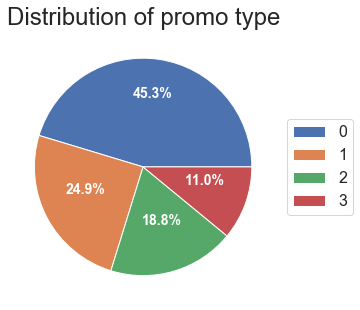

In [42]:
# 3) What is the usage of the promote method
study_tran.event.value_counts()
promo_val = list(study_tran.event.value_counts())
promo_type = list(study_tran.event.value_counts().index)

# Plot the data in a pie chart
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
data = promo_val
ingredients = promo_type


def func(pct, allvals):
    if pct/100.*np.sum(allvals)>0.01:
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n".format(pct, absolute)
    else:
        return None


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          loc="center left",
          fontsize = 16,
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=14, weight="bold")

ax.set_title("Distribution of promo type",fontsize=24, loc = 'left')

plt.show()


In [74]:
# 4) What is the accumulate usage of promote method with different gender
promo_val_male = list(study_tran.event.value_counts())
promo_type_male = list(study_tran.event.value_counts().index)

### Reserch into users transcript

1) What is the mean time of purchase for users

2) What is the frequency distribution of users

In [75]:
study_tran.head()

,person,event,value,time,amount,reward,offer id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0.0,0.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0.0,0.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0.0,0.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0.0,0.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0.0,0.0,bogo


In [76]:
# 1） what is the mean time of purchase for users
study_tran['person'].value_counts().mean()

18.031411764705883

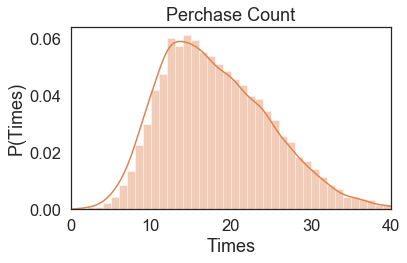

In [77]:
# 2) What is the frequency distribution of users
x1= list(study_tran['person'].value_counts())
# Plot the Age distribution of the starbuck user
current_palette = sns.color_palette()
sns.set(font_scale=1.5)
sns.set_style('white')
sns.distplot(x1,color=current_palette[1])
plt.xlabel('Times')
plt.xlim(0, 40)
plt.ylabel('P(Times)')
plt.title('Perchase Count')
plt.tight_layout()

### 6. Machine learning model
Machine learning models was built to predict whether a specific user would actually use a pomote code while receiving a specific one

Possible variable that could possiblily effect the decision making of whether to use the promo method are:
    1. Age of the user
    2. Gender of the user
    3. Time of the discount last
    4. Amount of the rewards
    5. Income of the user
    6. Difficulty
    7. Duration
    8. offer_type
    9. Source of the discount
    
    
Three models was built with different training algorithm
        
1. Logistic regression
2. Naive Bayes
3. Support Vector Machine

### Dataset preparation

In [78]:
# Resorces of processed data frame
# The portfolio of the promote code: portfolio
# Processed info of the users: profile
# The process of transcript info : study_tran

In [88]:
profile.head()
portfolio.head()
study_tran = transcript.copy()

In [91]:
# Before training model we merge the useful data into one dataframe
portfolio.rename(columns={'id':'offer_id'},inplace=True) 
study_tran.rename(columns={'person':'user_id', 'offer id':'offer_id','reward':'user_reward'},
                  inplace=True) 
profile.rename(columns={'id':'user_id'},inplace=True) # one-time code
part=pd.merge(study_tran,profile,how='left',on=['user_id']) 
merged=pd.merge(part,portfolio,how='left',on=['offer_id'])
merged.drop('became_member_on',axis = 1,inplace = True)

In [92]:
merged.head()

,user_id,event,value,time,amount,user_reward,offer_id,gender,age,income,reward,difficulty,duration,offer_type,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,0,NaN,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,M,68,70000.0,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4,None,0,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,None,0,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [90]:
study_model = merged.copy()
study_model.drop('user_id',axis = 1, inplace = True)
study_model.drop('value',axis = 1, inplace = True)
study_model.drop('offer_id',axis = 1, inplace = True)

,event,time,amount,user_reward,gender,age,income,reward,difficulty,duration,offer_type,web,email,mobile,social
0,offer received,0,0.0,0.0,F,75,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,offer received,0,0.0,0.0,None,0,NaN,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0
2,offer received,0,0.0,0.0,M,68,70000.0,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0
3,offer received,0,0.0,0.0,None,0,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,offer received,0,0.0,0.0,None,0,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [82]:
study_model.income.fillna(65404,inplace = True)
study_model.gender.fillna('N',inplace = True)

In [83]:
study_model.head()

,event,time,amount,user_reward,gender,age,income,reward,difficulty,duration,offer_type,web,email,mobile,social
0,offer received,0,0.0,0.0,F,75,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,offer received,0,0.0,0.0,N,0,65404.0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0
2,offer received,0,0.0,0.0,M,68,70000.0,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0
3,offer received,0,0.0,0.0,N,0,65404.0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,offer received,0,0.0,0.0,N,0,65404.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [84]:
'''
# Map gender and promo type into numbers 
# Map gender F to '1' and M to '2'
# Map event offer received to '1' and offer viewed to '2' 'offer completed' to '3'
# Map event bogo to '1' and discount to '2' 'informational' to 3
'''
study_model.gender.replace(to_replace = {'F':1,'M':2,'O':3,'N':0},inplace = True)
study_model.event.replace(to_replace = {'offer received':0,'offer viewed':1,'offer completed':2},inplace = True)
study_model.offer_type.replace(to_replace = {'bogo':1,'discount':2,'informational':3},inplace = True)

In [85]:
feature = study_model.copy()
feature = feature[feature['event']!='transaction']

In [86]:
#Check the data set used for machine learning
target = list(feature.event)

In [87]:
feature_mod.head()

NameError: name 'feature_mod' is not defined

In [ ]:
feature_mod = feature.copy()
feature_mod.drop('event',axis=1,inplace = True)
# Fix the problem when age is 0, and replace it with the mean of age of users
feature_mod.age.replace(to_replace = {0:47},inplace = True)
feature_mod.astype(float)

### Model construction

In [479]:
# Resources for training and prediction
# target ---- the reaction for users which receiving a promote code
# feature_mod ---- resources to predict the target

In [480]:
# Seperate the data into traing and test part
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(feature_mod, target,test_size = 0.33, random_state=0)

### Metrics of the evaluation method
In this project we want to evaluate the model with two parameters:

1) Precision

2) Recall

precision is the accuracy of single prediction of the model, it shows the accuracy of the model to make a single predicttion of user response to a sepcific offer.

Recall shows the broadth of the model,it is the parameter to evaluate whether the model could catch as much as positive response users as possible.

By conbining the two parameters, F1 score which is the Arithmetic mean of the precision and recall is applied as the core value for model evaluation. 

F1 = 2*precision*recall/(precision + recall)

Precision = TP / (TP + FP)
Recall = TP/ (TP + FN)

Reference : 
https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report

In [164]:
# Build functions to evaluate the model
def evaluate_model(model,X_test, y_test):
    '''
    Evaluation report of the model, and print the F1 scores
    INPUT: model, x_test and y_test
    OUPUT: evaluation report in text files 
    '''
    y_predict = model.predict(X_test)
    print(classification_report(y_test, y_predict))

#### Model 1 - Logistic Regression

In [482]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
evaluate_model(logreg,X_test, y_test)

              precision    recall  f1-score   support

           0       0.48      0.74      0.58     25354
           1       0.39      0.25      0.30     18854
           2       0.47      0.19      0.27     11094

    accuracy                           0.46     55302
   macro avg       0.45      0.39      0.38     55302
weighted avg       0.45      0.46      0.42     55302



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [492]:
with open('Logistic_regression_model.pkl', 'wb') as f1:
    pickle.dump(logreg, f1)

#### Model 2 - Naive Bayes

In [486]:
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
evaluate_model(gnb,X_test, y_test)

              precision    recall  f1-score   support

           0       0.61      0.68      0.64     25354
           1       0.49      0.41      0.44     18854
           2       1.00      1.00      1.00     11094

    accuracy                           0.65     55302
   macro avg       0.70      0.70      0.70     55302
weighted avg       0.65      0.65      0.65     55302



In [495]:
with open('Naive_Bayes_model_first.pkl', 'wb') as f2:
    pickle.dump(gnb, f2)

#### Model 3 - Suport Vector Machine

In [487]:
svm = SVC()
svm.fit(X_train, y_train)
evaluate_model(svm,X_test, y_test)

              precision    recall  f1-score   support

           0       0.46      1.00      0.63     25354
           1       0.00      0.00      0.00     18854
           2       0.00      0.00      0.00     11094

    accuracy                           0.46     55302
   macro avg       0.15      0.33      0.21     55302
weighted avg       0.21      0.46      0.29     55302



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [496]:
with open('Suport Vector Machine.pkl', 'wb') as f3:
    pickle.dump(svm, f3)

### Optimization of the model

Instead of directly probe into the hyper parameters that effect the training procedure, I decided to better shape the data frame first. Since I found some potential flows in the data set. Due to the following reasons
    
    1.The profile data may contains extreme data points:
    
    2.The profile data may contains empty cells for the data set
In this part we compared two different implantation method for model training and compare the result

In [27]:
# Back up the original data set
profile_ori = pd.read_json('data/profile.json', orient='records', lines=True)

In [28]:
# Back up the original data set
portfolio.rename(columns={'id':'offer_id'},inplace=True) 
study_tran.rename(columns={'person':'user_id', 'offer id':'offer_id','reward':'user_reward'},
                  inplace=True) 
profile_ori.rename(columns={'id':'user_id'},inplace=True) # one-time code
part = pd.merge(study_tran,profile_ori,how='left',on=['user_id']) 
merged_ori=pd.merge(part,portfolio,how='left',on=['offer_id'])
merged_ori.drop('became_member_on',axis = 1,inplace = True)
merged_ori.drop('user_id',axis = 1,inplace = True)
merged_ori.drop('value',axis = 1,inplace = True)
merged_ori.drop('offer_id',axis = 1,inplace = True)
feature_ori = merged_ori.copy()
feature_ori = feature_ori[feature_ori['event']!='transaction']
feature_ori.gender.replace(to_replace = {'F':1,'M':2,'O':3},inplace = True)
feature_ori.replace(to_replace = {'offer received':0,'offer viewed':1,'offer completed':2},inplace = True)
feature_ori.replace(to_replace = {'bogo':1,'discount':2,'informational':3},inplace = True)

In [29]:
# provide training data set for simply drop NA feature
feature_drop = feature_ori.copy()
feature_drop = feature_drop.fillna(0)
feature_drop = feature_drop[feature_drop['gender']!=0]
feature_drop = feature_drop[feature_drop['income']!=0]
feature_drop.head()
feature_drop.shape

(148805, 15)

### Training the Model with simple drop method

In [30]:
# Training the droped data set
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
target_drop = feature_drop.event
feature_drop.drop('event',axis=1,inplace = True)

In [31]:
# Build functions to evaluate the model
from sklearn.metrics import classification_report
def evaluate_model(model,X_test, y_test):
    '''
    Evaluation report of the model, and print the F1 scores
    INPUT: model, x_test and y_test
    OUPUT: evaluation report in text files 
    '''
    y_predict = model.predict(X_test)
    print(classification_report(y_test, y_predict))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(feature_drop,target_drop,test_size = 0.33, random_state=0)
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
evaluate_model(gnb,X_test, y_test)

              precision    recall  f1-score   support

           0       0.61      0.69      0.65     22141
           1       0.49      0.41      0.44     16227
           2       1.00      1.00      1.00     10738

    accuracy                           0.66     49106
   macro avg       0.70      0.70      0.70     49106
weighted avg       0.66      0.66      0.66     49106



### Training the Model with implentation method

In [33]:
# provide training data set for average implantation feature
feature_imp = feature_ori.copy()
feature_imp = feature_imp.fillna('0')
feature_imp = feature_imp[feature_imp['event'] != 'transaction']
feature_imp.income.astype(int)
feature_imp.income.replace(to_replace = {0:65400},inplace = True)
feature_imp.age.replace(to_replace = {118:47},inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [34]:
# Training the implentation data set
target_imp = feature_imp.event
feature_imp.drop('event',axis=1,inplace = True)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(feature_imp,target_imp,test_size = 0.33, random_state=0)
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
evaluate_model(gnb,X_test, y_test)

              precision    recall  f1-score   support

           0       0.59      0.75      0.66     25354
           1       0.49      0.33      0.39     18854
           2       1.00      0.97      0.99     11094

    accuracy                           0.65     55302
   macro avg       0.69      0.68      0.68     55302
weighted avg       0.64      0.65      0.63     55302



### Result comparison
The F1 score for simply drop method is 0.66 while for implentation is 0.65. Surprisingly the implentation method doesn't improve the accuracy of the model, for those data simplily drop them could be the case

### Training the Model with less variables

Not all the variables provide useful information for the model, let's see if we can drop those unrelated variable to simplify the model

In [38]:
feature_drop.drop('time',axis = 1,inplace = True)
feature_drop.drop('duration',axis = 1,inplace = True)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(feature_drop,target,test_size = 0.33, random_state=0)
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
evaluate_model(gnb,X_test, y_test)

              precision    recall  f1-score   support

           0       0.60      0.71      0.65     22141
           1       0.48      0.36      0.41     16227
           2       1.00      1.00      1.00     10738

    accuracy                           0.66     49106
   macro avg       0.69      0.69      0.69     49106
weighted avg       0.65      0.66      0.65     49106



### Discussion
if we drop the time and duration variable, the f1 score for the model doesn't change which indicates, those values are not to relevent in prediction the the user response